First 5 rows of the dataset:
   RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0        747    15787619      Hsieh          844    France    Male   18   
1       1620    15770309   McDonald          656    France    Male   18   
2       1679    15569178  Kharlamov          570    France  Female   18   
3       2022    15795519   Vasiliev          716   Germany  Female   18   
4       2137    15621893   Bellucci          727    France    Male   18   

   Tenure    Balance  EstimatedSalary  Exited  
0       2  160980.03        145936.28       0  
1      10  151762.74        127014.32       0  
2       4   82767.42         71811.90       0  
3       3  128743.80        197322.13       0  
4       4  133550.67         46941.41       0  

Number of rows and columns:
(10000, 11)

Column names and data types:
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object

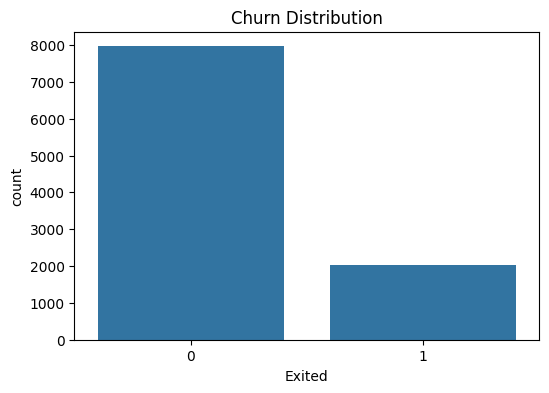

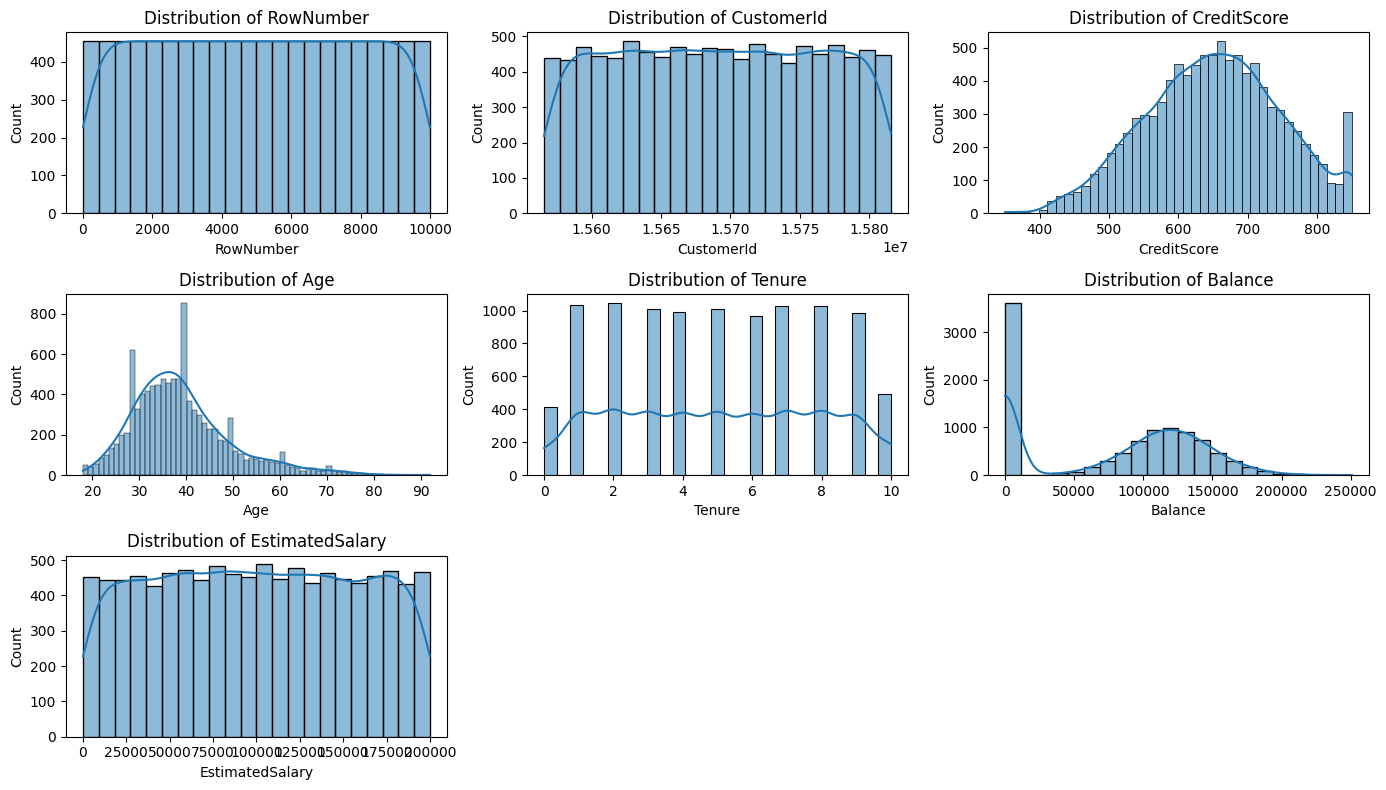

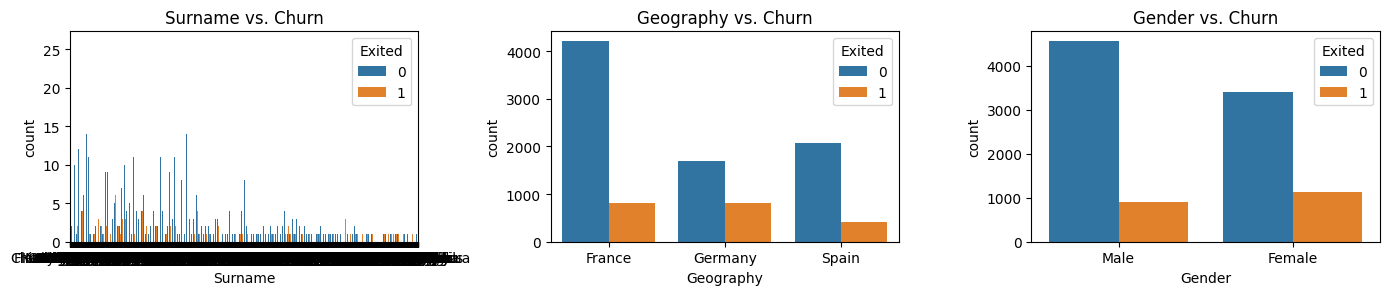

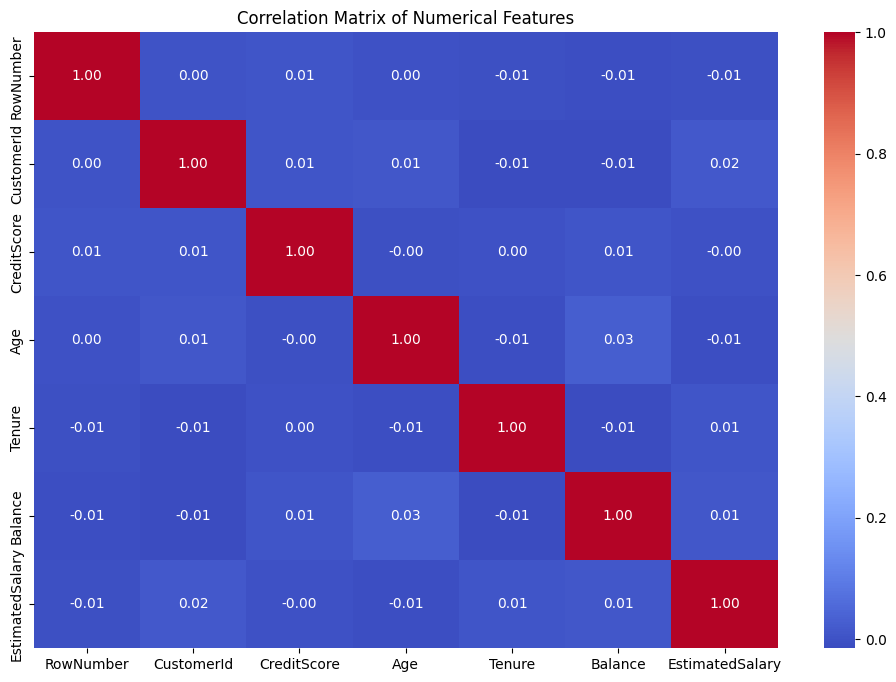

Before SMOTE - y_train distribution:
Exited
0    6373
1    1627
Name: count, dtype: int64

After SMOTE - y_train_resampled distribution:
Exited
1    6373
0    6373
Name: count, dtype: int64

Training and Evaluating: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1590
           1       0.41      0.34      0.37       410

    accuracy                           0.76      2000
   macro avg       0.62      0.61      0.61      2000
weighted avg       0.75      0.76      0.76      2000



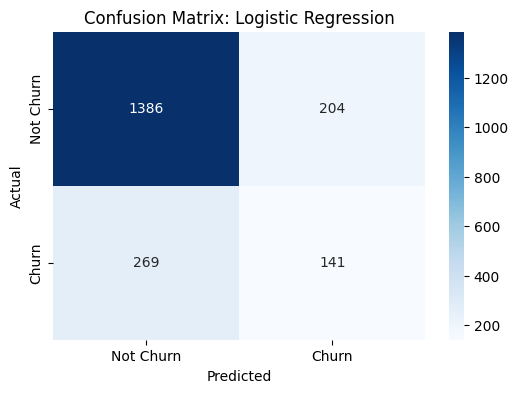

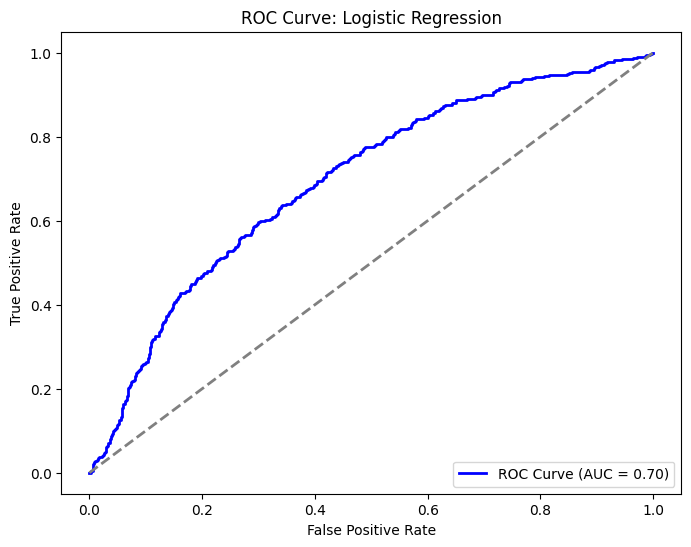


Training and Evaluating: Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1590
           1       0.59      0.35      0.44       410

    accuracy                           0.82      2000
   macro avg       0.72      0.64      0.66      2000
weighted avg       0.79      0.82      0.80      2000



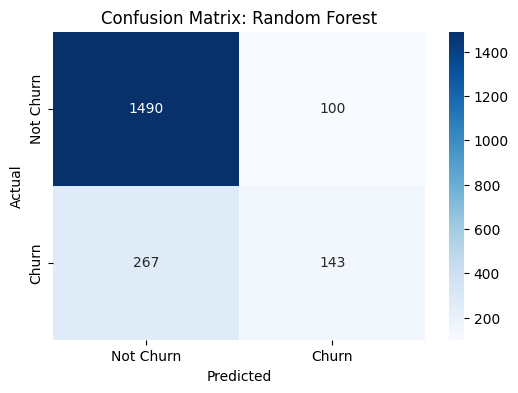

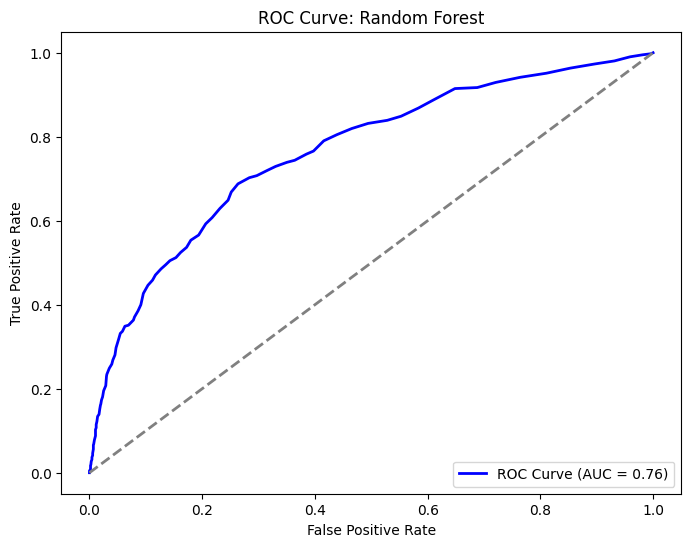


Training and Evaluating: Gradient Boosting

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.85      1590
           1       0.45      0.62      0.52       410

    accuracy                           0.77      2000
   macro avg       0.67      0.71      0.69      2000
weighted avg       0.80      0.77      0.78      2000



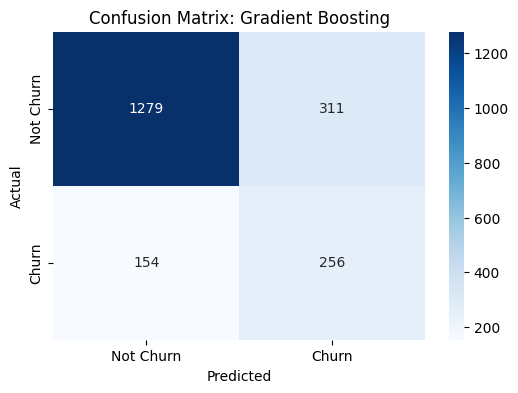

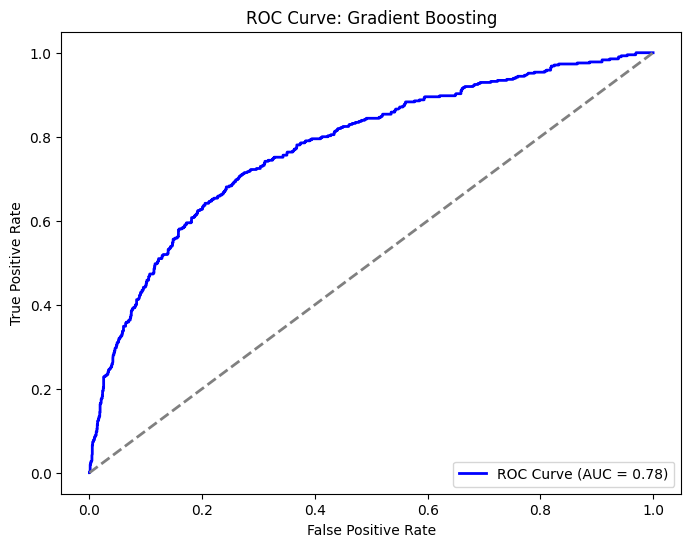

Best model saved as 'best_churn_model.joblib'


In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, f1_score
from joblib import dump


# Load dataset
data = pd.read_csv("analysis.csv")

# Initial dataset exploration
print("First 5 rows of the dataset:")
print(data.head())

print("\nNumber of rows and columns:")
print(data.shape)

print("\nColumn names and data types:")
print(data.dtypes)

print("\nMissing values in each column:")
print(data.isnull().sum())

print("\nStatistical summary of numerical columns:")
print(data.describe())

# Visualize churn distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Exited')
plt.title('Churn Distribution')
plt.show()

# Separate numerical and categorical columns
numerical_cols = data.select_dtypes(include=np.number).columns.tolist()
categorical_cols = data.select_dtypes(include='object').columns.tolist()

# Exclude 'Exited' from numerical columns since it's the target variable
numerical_cols = [col for col in numerical_cols if col != 'Exited']

# Visualize numerical feature distributions
plt.figure(figsize=(14, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Visualize relationships between categorical variables and churn
plt.figure(figsize=(14, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=data, x=col, hue='Exited')
    plt.title(f'{col} vs. Churn')
plt.tight_layout()
plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(data[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Data preprocessing
# Drop rows with missing values
data = data.dropna()

# Cap outliers at 1st and 99th percentiles
for col in numerical_cols:
    q_low = data[col].quantile(0.01)
    q_high = data[col].quantile(0.99)
    data[col] = np.where(data[col] < q_low, q_low, data[col])
    data[col] = np.where(data[col] > q_high, q_high, data[col])

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Separate features and target variable
X = data.drop('Exited', axis=1)
y = data['Exited']

# Standardize numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE - y_train distribution:")
print(y_train.value_counts())

print("\nAfter SMOTE - y_train_resampled distribution:")
print(y_train_resampled.value_counts())

# Model training and evaluation
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

for model_name, model in models.items():
    print(f"\nTraining and Evaluating: {model_name}")
    # Train the model
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on test data
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Not Churn", "Churn"], 
                yticklabels=["Not Churn", "Churn"])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Save the best model
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train_resampled, y_train_resampled)
dump(best_model, "best_churn_model.joblib")
print("Best model saved as 'best_churn_model.joblib'")
